<a href="https://colab.research.google.com/github/Thrcordeiro/SeriesTemporais/blob/main/lynx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTANDO BIBLIOTECAS

!pip install pmdarima

# lib to handle with time series
import pandas as pd
# lib to plot the data
import matplotlib.pyplot as plt
# lib to use the decompositio in the time series
from statsmodels.tsa.seasonal import seasonal_decompose
# lib to use the acf and pcf correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from pmdarima.arima import auto_arima, arima
# from pmdarima.utils import tsdisplay
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
import pmdarima as pm


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6


import warnings
warnings.filterwarnings("ignore")



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00


In [ ]:
# to read the time series

df = pd.read_csv('/content/lynx.txt', header=0)


In [ ]:
df.head(3)

,data
0,269
1,321
2,585


<Axes: >

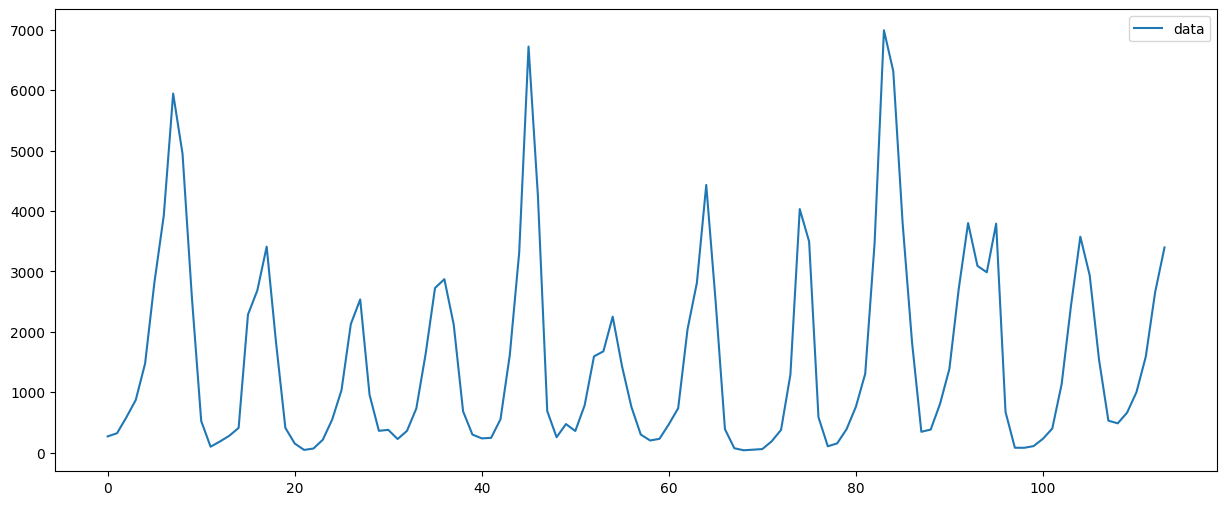

In [ ]:
df.plot() # Vendo o comportamento dos dados

Observa-se que os dados não mostram tendencia, e sim um certo grau de sazonalidade

Text(0.5, 1.0, 'Lynx Seasonal Decomposition')

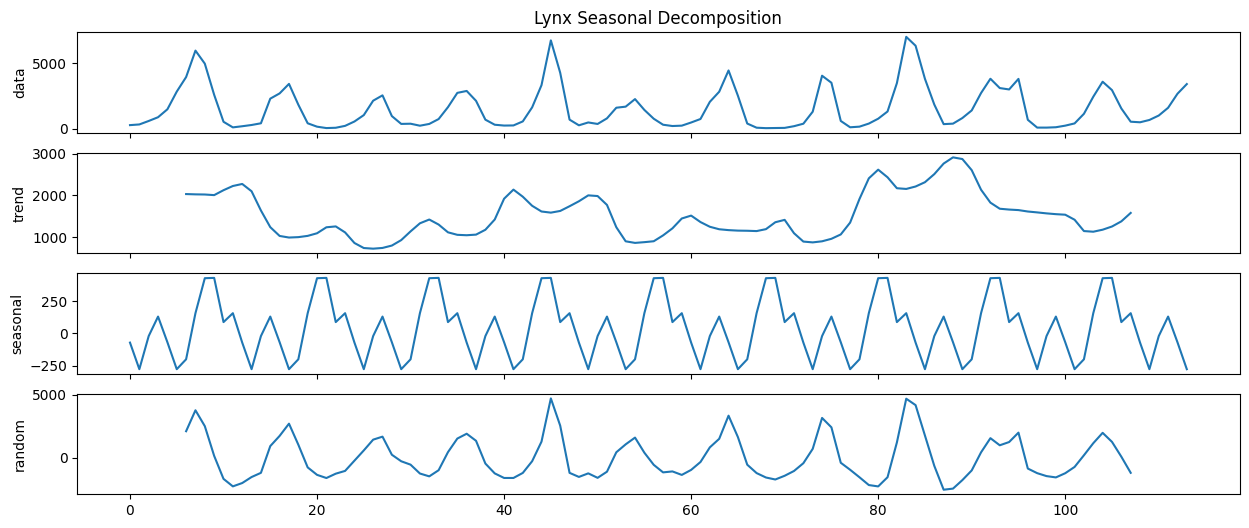

In [ ]:
from pmdarima import arima
from pmdarima import datasets
from pmdarima import utils

figure_kwargs = {'figsize': (15, 6)}  #
# Decompose the airpassengers dataset into trend, seasonal and random parts.

# DESCOMPOSIÇÂO DOS DADOS MEDIANTE A FUNÇÂO "DECOMPOSE"
decomposed = arima.decompose(df.values.reshape(-1),
                             'additive', m=12)

# Plot the decomposed signal of airpassengers as a subplot

axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,
                             show=False)
axes[0].set_title("Lynx Seasonal Decomposition")

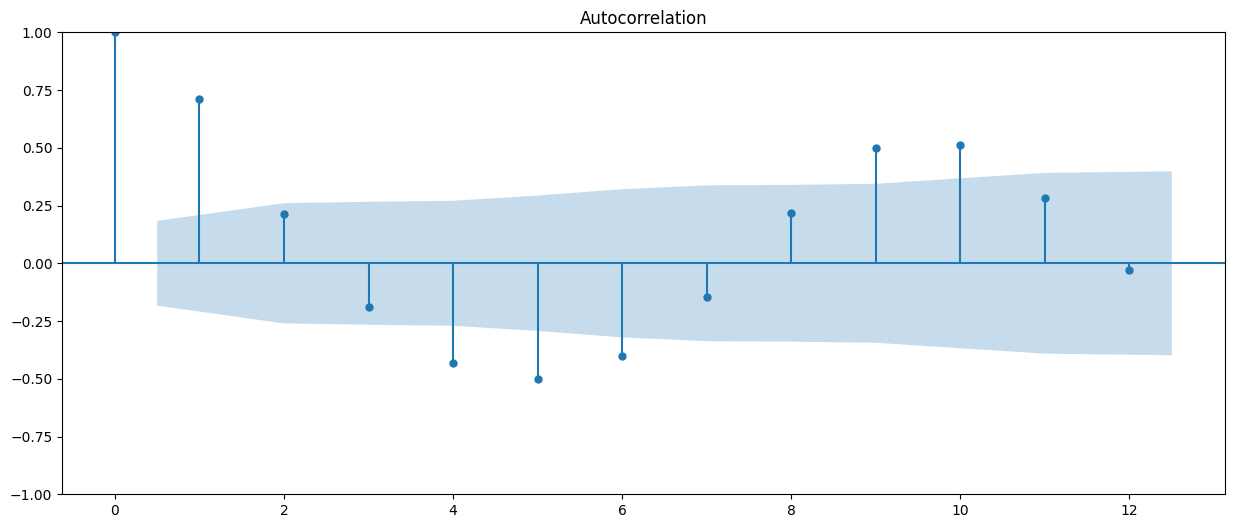

In [ ]:
# to use the acf
plot_acf(df, lags=12)
plt.show()


 MA = 1  Valor escolhido

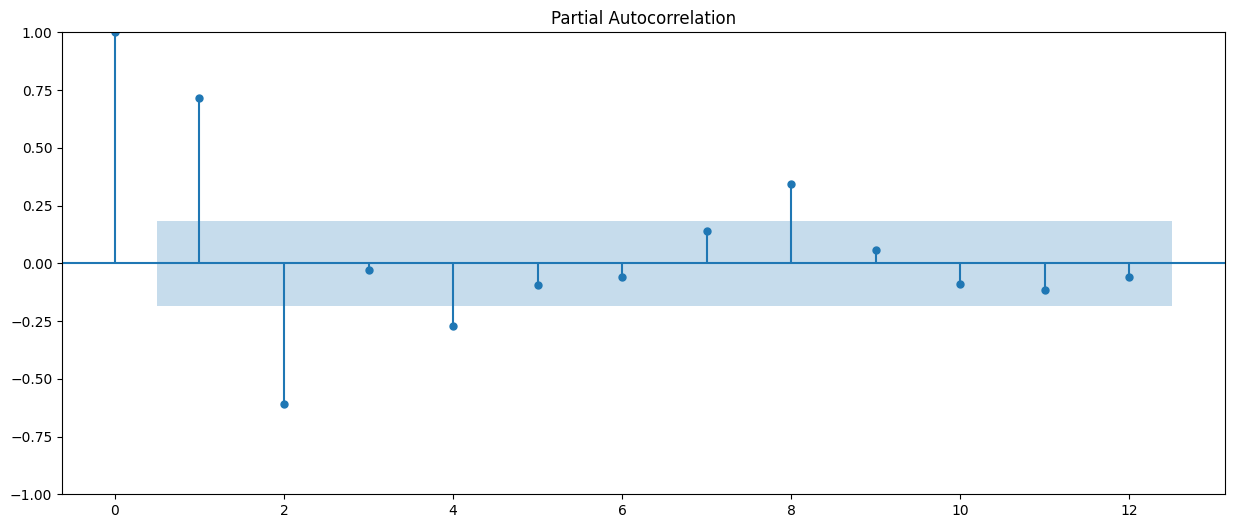

In [ ]:
# to use the pacf
plot_pacf(df, lags=12)
plt.show()
# Observamos AutocorrelaçãoParcial para determinar o valor de AR

AR = 1

## Modelagem (AR, MA, ARIMA)




### Teste de Estacionarieade

In [ ]:
# Test for stationarity using the Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] <= 0.05:
    print('The data is stationary.')
else:
    print('The data is non-stationary.')


ADF Statistic: -2.9963036751425576
p-value: 0.03524103535901378
Critical Values:
	1%: -3.494
	5%: -2.889
	10%: -2.582
The data is stationary.


Não será necessário fazer diferenciações, pois *o teste de estacionaridade* mostrou que os dados são estacionarios.




In [ ]:
# PREPARAÇÃO DOS DADOS

m=12
test_size=12
y = df.values
train_len = len(y) - test_size

In [ ]:
#Normalização
min_max_scaler = MinMaxScaler(feature_range=(0,1))
min_max_scaler.fit(y[0:train_len].reshape(-1, 1))
serie_normalized = min_max_scaler.transform(y.reshape(-1, 1)).flatten()


In [ ]:
# SEPARANDO DADOS DE TREINO E TESTE

y_train, y_test = train_test_split(serie_normalized, train_size=train_len)
print("train_size", len(y_train))
print("test_size", len(y_test))

train_size 102
test_size 12


### AR

In [ ]:
model_AR = pm.arima.ARIMA(order=(1,0,1)) # AR, Grau de Diferenciação, MA
model_AR.fit(y_train)

ARIMA(order=(1, 0, 1))

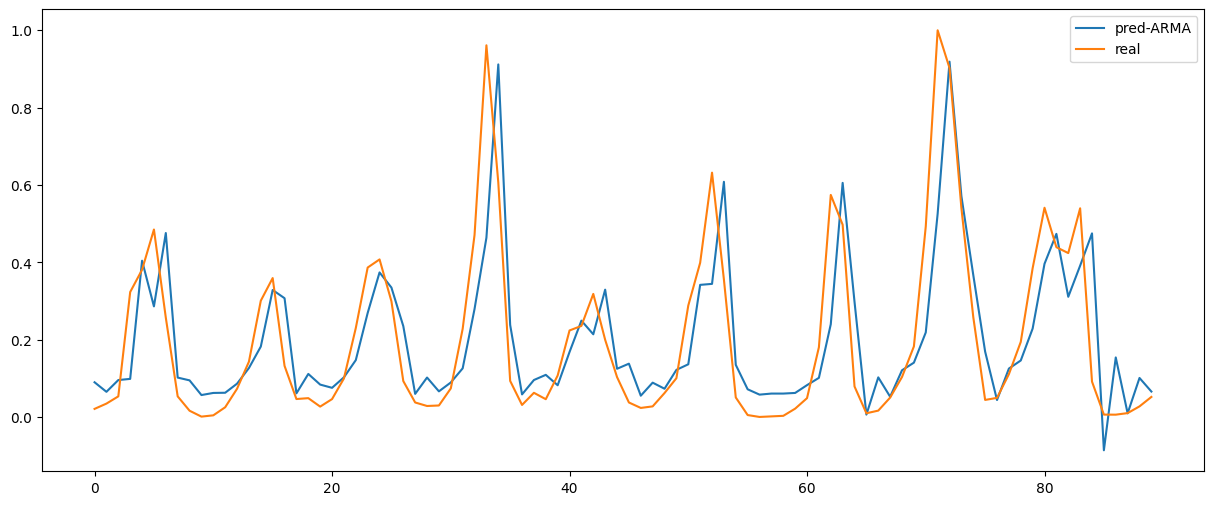

In [ ]:
predictions_train_AR = model_AR.predict_in_sample()
plt.plot(predictions_train_AR[m:], label='pred-ARMA')
plt.plot(y_train[m:], label='real')
plt.legend()

In [ ]:
def forecast_one_step():
    fc = model_AR.predict(n_periods=1, return_conf_int=False)
    return fc.tolist()[0]
    # np.asarray(conf_int).tolist()[0])

forecasts = []
# confidence_intervals = []

for new_ob in y_test:
    fc = forecast_one_step()
    forecasts.append(fc)
    # confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model_AR.update(new_ob)

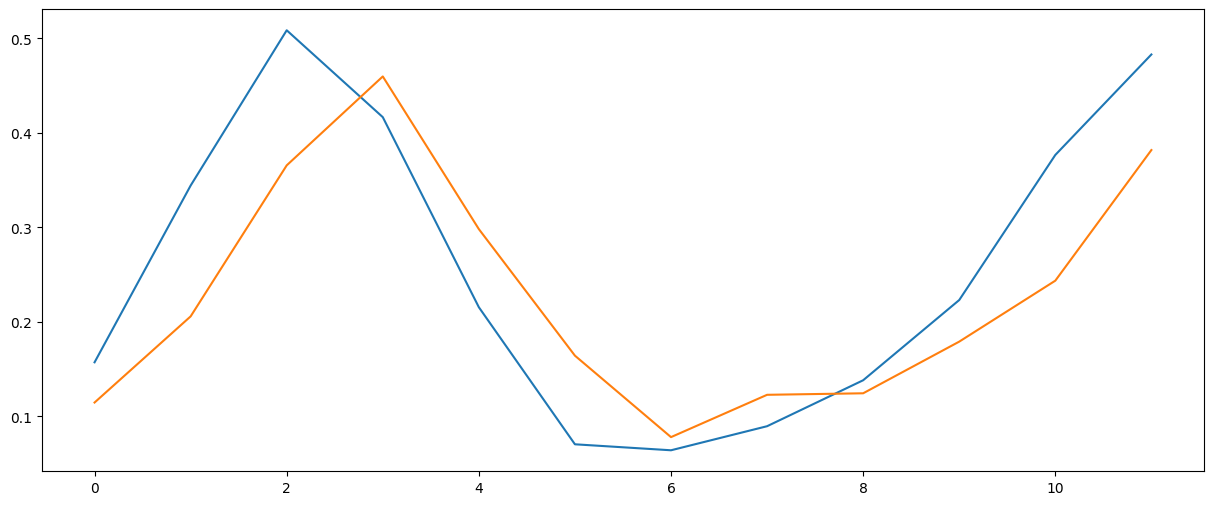

In [ ]:
plt.plot(y_test)
plt.plot(forecasts)

In [ ]:
print("freq", m)
print("Test MSE: %.10f" % mse(y_test, forecasts))
print("Test MAE: %.10f" % mae(y_test, forecasts))

freq 12
Test MSE: 0.0075173164
Test MAE: 0.0735349222


Avaliando o Resíduo

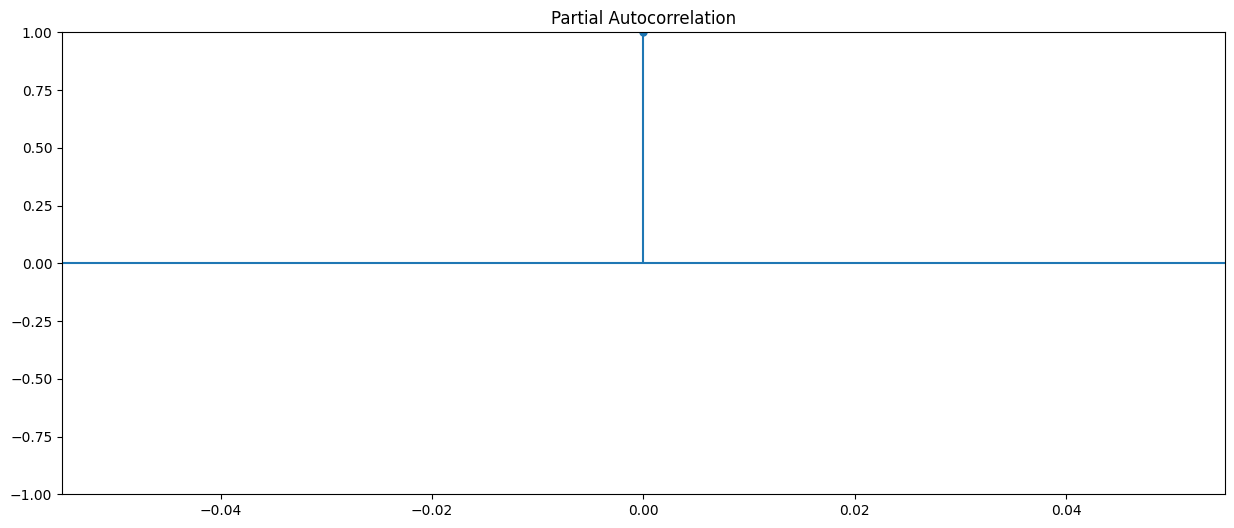

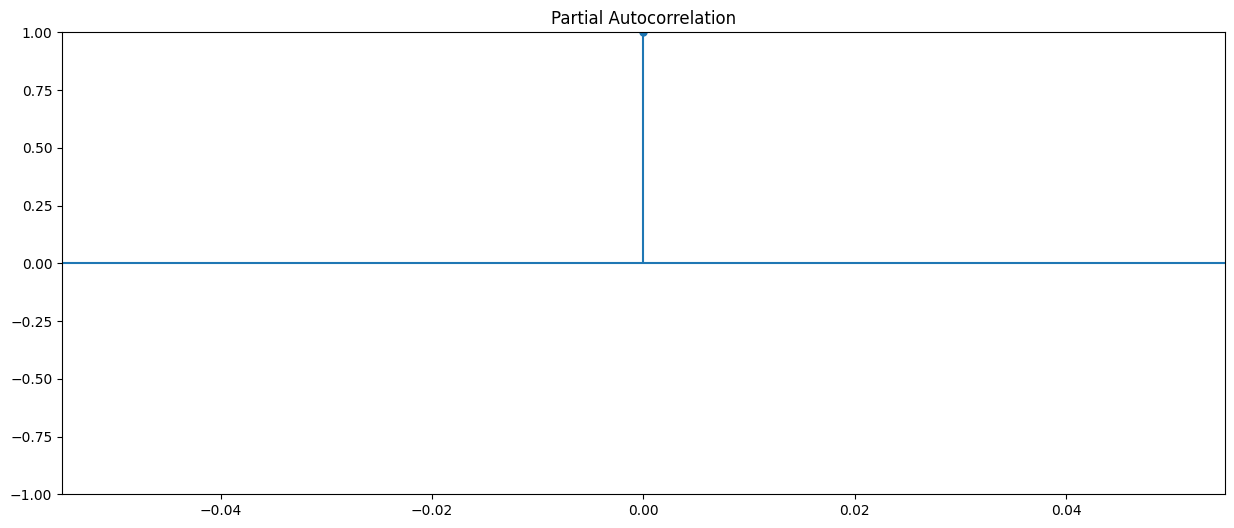

In [ ]:
## Avaliamos o Residuo para saber se a media e desvio dos nossos dados são constantes

import statsmodels.tsa.api as smt

# Uso o resultados da função decomposed para obter os residuos
dados_ruido = decomposed[-1]

smt.graphics.plot_pacf(dados_ruido, lags=30, alpha=0.5)

### ARIMA

#### Diferenciação (I)

<Axes: >

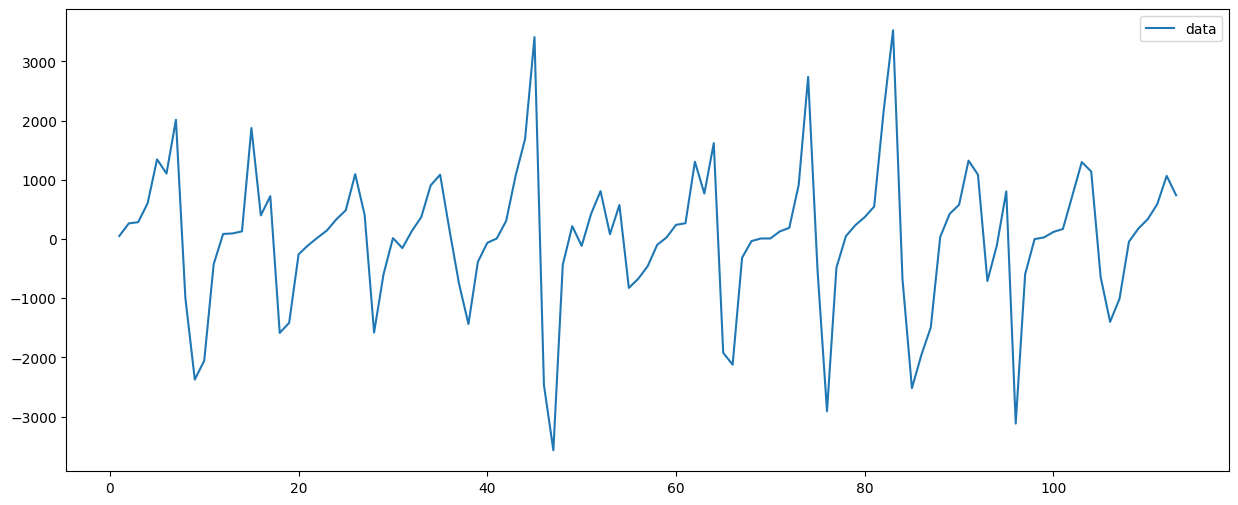

In [ ]:
df_diff = df.diff(1)
df_diff.plot()

In [ ]:
model_ARIMA = pm.arima.ARIMA(order=(1,0,0))
model_ARIMA.fit(y_train)

ARIMA(order=(1, 0, 0))

In [ ]:
def forecast_one_step():
    fc = model_ARIMA.predict(n_periods=1, return_conf_int=False)
    return fc.tolist()[0]

forecasts_ARIMA = []
for new_ob in y_test:
    fc = forecast_one_step()
    forecasts_ARIMA.append(fc)
    # confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model_ARIMA.update(new_ob)

In [ ]:
print("freq", m)
print("Test MSE: %.10f" % mse(y_test, forecasts_ARIMA))
print("Test MAE: %.10f" % mae(y_test, forecasts_ARIMA))

freq 12
Test MSE: 0.0143025460
Test MAE: 0.0989659094


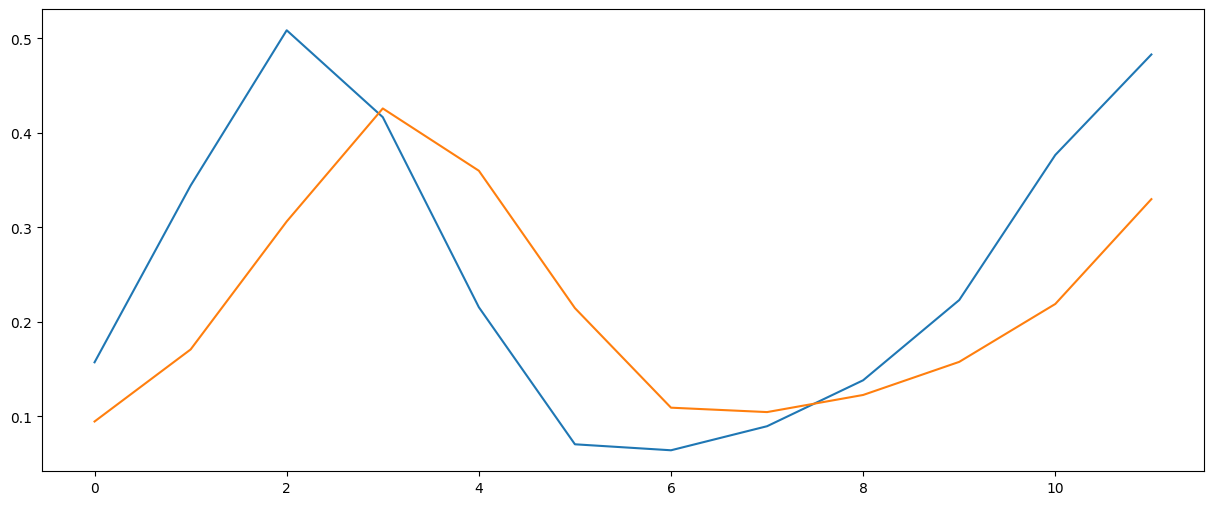

In [ ]:
plt.plot(y_test)
plt.plot(forecasts_ARIMA)

### AUTO ARIMA

In [ ]:
model_AutoARIMA = Pipeline(
    [
        ##('boxcox', BoxCoxEndogTransformer()),
        (
            "auto - arima",
            pm.AutoARIMA(
                trace=True,
                suppress_warnings=True,
                max_p=10,
                stepwise=True,
                seasonal=False,
                m=m,
            ),
        )
    ]
)

model_AutoARIMA.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-93.547, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=55.571, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-69.533, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-39.134, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-95.384, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-79.241, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-95.876, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-95.546, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-93.262, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-104.966, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-81.689, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-74.806, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-113.425, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-115.012, Time=0.09 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-11

Pipeline(steps=[('auto - arima',
                 AutoARIMA(m=12, max_p=10, seasonal=False, trace=True))])

In [ ]:
def forecast_one_step():
    fc = model_AutoARIMA.predict(n_periods=1, return_conf_int=False)
    return fc.tolist()[0]
forecasts_auto_ARIMA = []
for new_ob in y_test:
    fc = forecast_one_step()
    forecasts_auto_ARIMA.append(fc)
    # confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model_AutoARIMA.update(new_ob)

In [ ]:
print("freq", m)
print("Test MSE: %.10f" % mse(y_test, forecasts_auto_ARIMA))
print("Test MAE: %.10f" % mae(y_test, forecasts_auto_ARIMA))

freq 12
Test MSE: 0.0044377287
Test MAE: 0.0558908139


Conclui-se que o AutoArima se apresentou como melhor modelo um ARIMA(2,0,0).

Já o AR com (1,0,1) apresentou um resíduo constante.
